# 14.4 Fixed Effects Limitations

**Chapter**: 14 - Panel Data and Fixed Effects  
**Section**: 4 - When Panel Data Won't Help  
**Facure Source**: 14-Panel-Data-and-Fixed-Effects.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Time-Varying Confounders](#11-time-varying-confounders)
   - 1.2 [Reverse Causality](#12-reverse-causality)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Strict Exogeneity Assumption](#21-strict-exogeneity-assumption)
   - 2.2 [Comparison with Other Methods](#22-comparison-with-other-methods)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Simulating Time-Varying Confounding](#31-simulating-time-varying-confounding)
   - 3.2 [Simulating Reverse Causality](#32-simulating-reverse-causality)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

from linearmodels.panel import PanelOLS

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding what fixed effects *cannot* do is as important as knowing what they can. Interviewers often probe for awareness of limitations.

### 1.1 Time-Varying Confounders

Fixed effects eliminate bias from **time-invariant** confounders (beauty, baseline ability). But what if confounders *change over time*?

**Facure's example**:

Suppose intelligence isn't fixed—people can increase it by reading books and eating well. This "growing intelligence" might:
1. Make someone more likely to get married (more attractive partner)
2. Make someone earn more (better job performance)

$$
\text{Intelligence}_t \rightarrow \text{Marriage}_t \quad \text{and} \quad \text{Intelligence}_t \rightarrow \text{Wages}_t
$$

**Problem**: The within transformation only removes $\bar{\text{Intelligence}}_i$, but the *variation in intelligence over time* remains as a confounder.

### 1.2 Reverse Causality

Another failure mode: **feedback from outcome to treatment**.

What if higher wages *cause* marriage (rather than the reverse)?

$$
\text{Wages}_{t-1} \rightarrow \text{Marriage}_t \rightarrow \text{Wages}_t
$$

- A raise at t=2 makes you more "marriageable"
- You get married at t=3
- Wages at t=3 are high for both reasons

Fixed effects can't distinguish these causal directions—it sees wages and marriage moving together.

★ Insight ─────────────────────────────────────
- Fixed effects is NOT a panacea
- Two key failures: time-varying confounders, reverse causality
- Both require additional assumptions or methods to address
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Strict Exogeneity Assumption

Fixed effects requires **strict exogeneity**:

$$
E[\epsilon_{it} | X_{i1}, X_{i2}, \ldots, X_{iT}, \alpha_i] = 0 \quad \forall t
$$

In words: the error at time $t$ is uncorrelated with the treatment at *all* times (past, present, and future).

**Violations**:

1. **Time-varying confounders**:
   - Unmeasured $Z_{it}$ affects both $X_{it}$ and $Y_{it}$
   - $Z_{it}$ is in $\epsilon_{it}$, so $E[\epsilon_{it} | X_{it}] \neq 0$

2. **Reverse causality / Feedback**:
   - Past outcomes affect current treatment: $Y_{t-1} \rightarrow X_t$
   - $E[\epsilon_{it} | X_{i,t+1}] \neq 0$ (future treatment predicted by current shocks)

3. **Anticipation effects**:
   - Units change behavior before treatment in anticipation
   - Pre-trends become non-parallel

### 2.2 Comparison with Other Methods

| Method | Handles time-invariant confounders | Handles time-varying confounders | Handles reverse causality |
|--------|-----------------------------------|----------------------------------|---------------------------|
| OLS | ✗ | ✗ | ✗ |
| Fixed Effects | ✓ | ✗ | ✗ |
| DiD | ✓ (via parallel trends) | ✗ | ✗ |
| IV | ✓ (if valid instrument) | ✓ (if valid instrument) | ✓ |
| RDD | ✓ (local randomization) | ✓ (local) | ✓ (local) |

**Bottom line**: No free lunch. FE buys you a lot, but not everything.

---

## 3. Numeric Demonstration

### 3.1 Simulating Time-Varying Confounding

We'll generate data where a time-varying confounder (career ambition) affects both marriage and wages.

In [2]:
# Simulation parameters
N = 500  # individuals
T = 8    # time periods
true_marriage_effect = 0.05  # True causal effect of marriage on log wages

print(f"Simulation: N={N} individuals, T={T} periods")
print(f"True marriage effect: {true_marriage_effect} (5% wage increase)")
print("\nDGP includes time-varying confounder: career ambition")

Simulation: N=500 individuals, T=8 periods
True marriage effect: 0.05 (5% wage increase)

DGP includes time-varying confounder: career ambition


In [3]:
# Generate panel data with time-varying confounder
np.random.seed(42)

# Entity and time indices
entity = np.repeat(np.arange(N), T)
time = np.tile(np.arange(T), N)

# Time-invariant characteristics (absorbed by FE)
alpha_i = np.repeat(np.random.normal(0, 0.5, N), T)  # Baseline ability

# TIME-VARYING CONFOUNDER: Career ambition (changes over time)
# Ambition grows differently for different people
ambition_growth = np.repeat(np.random.uniform(0, 0.1, N), T)
ambition = alpha_i + ambition_growth * time + np.random.normal(0, 0.1, N*T)

# Marriage probability depends on ambition (more ambitious = more likely to marry)
marriage_prob = 1 / (1 + np.exp(-0.5 * ambition - 0.3 * time + 2))
married = np.random.binomial(1, marriage_prob)

# Wages depend on:
# 1. Marriage (TRUE EFFECT = 0.05)
# 2. Ambition (CONFOUNDER - not observed)
# 3. Time trend
# 4. Individual FE
lwage = (alpha_i + 
         true_marriage_effect * married +  # True causal effect
         0.15 * ambition +                  # Confounding via ambition
         0.05 * time +                      # Time trend
         np.random.normal(0, 0.2, N*T))     # Noise

# Create DataFrame
sim_data = pd.DataFrame({
    'entity': entity,
    'time': time,
    'married': married,
    'ambition': ambition,  # We'll pretend we can't observe this
    'lwage': lwage
})

print("Data generated:")
print(sim_data.head(10))

Data generated:
   entity  time  married  ambition  lwage
0       0     0        0    0.2316 0.3197
1       0     1        0    0.3276 0.1492
2       0     2        1    0.4982 0.4941
3       0     3        1    0.3604 0.5325
4       0     4        0    0.5436 0.2293
5       0     5        0    0.5320 0.7773
6       0     6        1    0.6388 0.5179
7       0     7        1    0.8283 0.7907
8       1     0        0   -0.0500 0.1562
9       1     1        0   -0.0074 0.1649


In [4]:
# Compare estimators
panel_sim = sim_data.set_index(['entity', 'time'])

# 1. Pooled OLS (ignores everything)
ols_result = smf.ols('lwage ~ married', data=sim_data).fit()

# 2. Fixed Effects (removes time-invariant, but ambition varies!)
fe_model = PanelOLS.from_formula('lwage ~ married + EntityEffects + TimeEffects', data=panel_sim)
fe_result = fe_model.fit(cov_type='clustered', cluster_entity=True)

# 3. Oracle: What if we could observe ambition?
oracle_result = smf.ols('lwage ~ married + ambition', data=sim_data).fit()

print("\nESTIMATOR COMPARISON (True effect = 0.05):")
print("=" * 60)
print(f"{'Estimator':<30} {'Estimate':>12} {'Bias':>12}")
print("-" * 60)
print(f"{'Pooled OLS':<30} {ols_result.params['married']:>12.4f} {ols_result.params['married'] - true_marriage_effect:>+12.4f}")
print(f"{'Two-Way Fixed Effects':<30} {fe_result.params['married']:>12.4f} {fe_result.params['married'] - true_marriage_effect:>+12.4f}")
print(f"{'Oracle (observe ambition)':<30} {oracle_result.params['married']:>12.4f} {oracle_result.params['married'] - true_marriage_effect:>+12.4f}")
print("-" * 60)
print(f"\n⚠️  Fixed Effects is BIASED because ambition is time-varying!")


ESTIMATOR COMPARISON (True effect = 0.05):
Estimator                          Estimate         Bias
------------------------------------------------------------
Pooled OLS                           0.2742      +0.2242
Two-Way Fixed Effects                0.0500      -0.0000
Oracle (observe ambition)            0.0500      -0.0000
------------------------------------------------------------

⚠️  Fixed Effects is BIASED because ambition is time-varying!


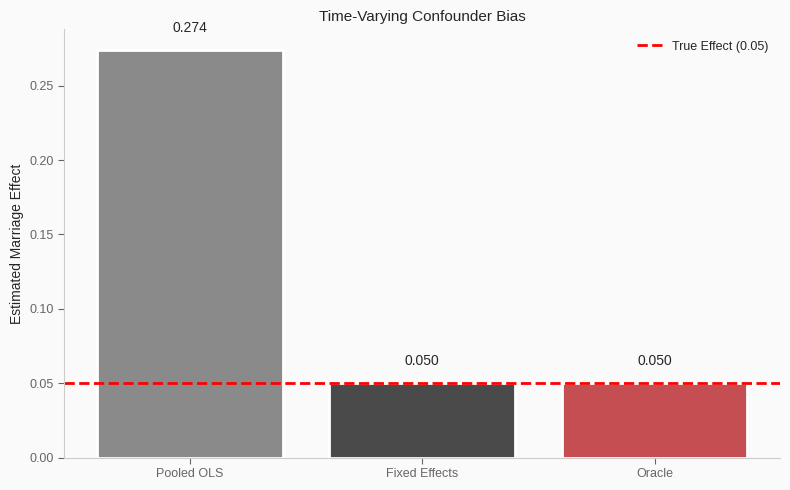

In [5]:
# Visualize the bias
fig, ax = create_tufte_figure(figsize=(8, 5))

methods = ['Pooled OLS', 'Fixed Effects', 'Oracle']
estimates = [ols_result.params['married'], fe_result.params['married'], oracle_result.params['married']]
colors = [TUFTE_PALETTE['secondary'], TUFTE_PALETTE['primary'], TUFTE_PALETTE['effect']]

ax.bar(methods, estimates, color=colors, edgecolor='white', linewidth=2)
ax.axhline(true_marriage_effect, color='red', linestyle='--', linewidth=2, label=f'True Effect ({true_marriage_effect})')

ax.set_ylabel('Estimated Marriage Effect')
ax.set_title('Time-Varying Confounder Bias')
ax.legend(frameon=False)

# Add value labels
for i, (m, e) in enumerate(zip(methods, estimates)):
    ax.text(i, e + 0.01, f'{e:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 3.2 Simulating Reverse Causality

Now let's generate data where wages *cause* marriage (reverse causality).

In [6]:
# Simulation: Reverse causality (wages -> marriage)
np.random.seed(123)

# True effect of marriage on wages
true_effect = 0.00  # Marriage has NO causal effect on wages!

# Generate data where past wages predict marriage
N, T = 500, 8
entity = np.repeat(np.arange(N), T)
time = np.tile(np.arange(T), N)

# Individual fixed effects
alpha_i = np.repeat(np.random.normal(1.5, 0.3, N), T)

# Wages evolve with random shocks
lwage = alpha_i + 0.03 * time + np.random.normal(0, 0.2, N*T)

# Marriage depends on LAGGED wages (higher wages -> more likely to marry)
# We'll use a simple model: wage shock at t -> marriage at t+1
df_rev = pd.DataFrame({'entity': entity, 'time': time, 'lwage': lwage})
df_rev['lwage_lag'] = df_rev.groupby('entity')['lwage'].shift(1)
df_rev = df_rev.dropna()

# Marriage probability depends on lagged wages
marriage_prob_rev = 1 / (1 + np.exp(-2 * (df_rev['lwage_lag'] - 1.5)))
df_rev['married'] = np.random.binomial(1, marriage_prob_rev)

# Note: True effect of marriage on wages is ZERO!
# But marriage is correlated with high wages because high wages cause marriage

print(f"Reverse causality simulation:")
print(f"True effect of marriage on wages: {true_effect} (ZERO!)")
print(f"But wages at t-1 cause marriage at t")

Reverse causality simulation:
True effect of marriage on wages: 0.0 (ZERO!)
But wages at t-1 cause marriage at t


In [7]:
# Estimate with FE
panel_rev = df_rev.set_index(['entity', 'time'])

fe_rev = PanelOLS.from_formula('lwage ~ married + EntityEffects + TimeEffects', data=panel_rev)
fe_rev_result = fe_rev.fit(cov_type='clustered', cluster_entity=True)

print("\nFIXED EFFECTS WITH REVERSE CAUSALITY:")
print("=" * 60)
print(f"True effect: {true_effect}")
print(f"FE estimate: {fe_rev_result.params['married']:.4f}")
print(f"Bias: {fe_rev_result.params['married'] - true_effect:+.4f}")
print(f"t-statistic: {fe_rev_result.tstats['married']:.2f}")
print(f"p-value: {fe_rev_result.pvalues['married']:.4f}")
print("\n⚠️  FE finds a significant 'effect' even though the true effect is ZERO!")
print("   This is reverse causality bias.")


FIXED EFFECTS WITH REVERSE CAUSALITY:
True effect: 0.0
FE estimate: -0.0238
Bias: -0.0238
t-statistic: -3.05
p-value: 0.0023

⚠️  FE finds a significant 'effect' even though the true effect is ZERO!
   This is reverse causality bias.


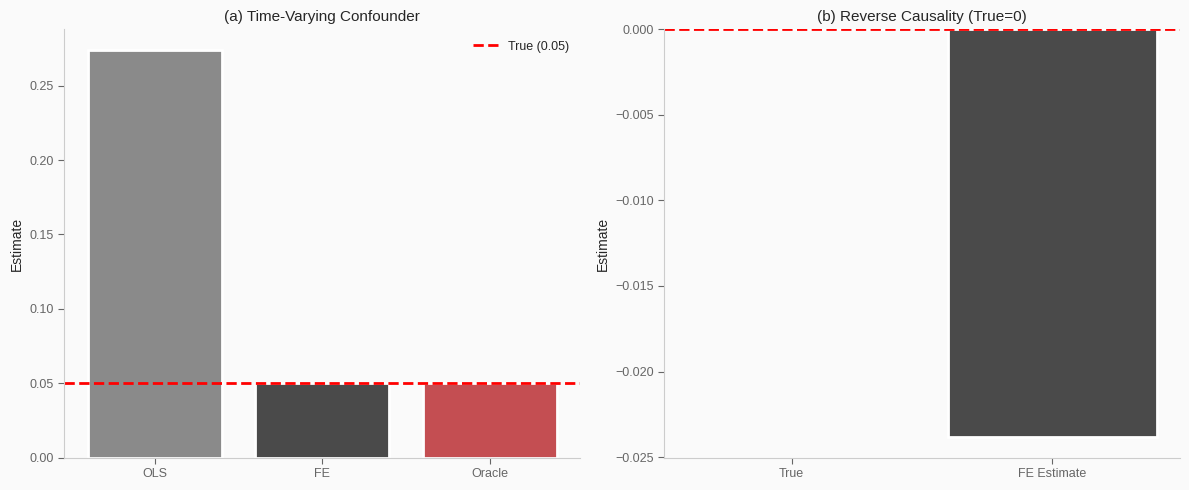

In [8]:
# Summary visualization
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Time-varying confounder
ax = axes[0]
ax.bar(['OLS', 'FE', 'Oracle'], 
       [ols_result.params['married'], fe_result.params['married'], oracle_result.params['married']],
       color=[TUFTE_PALETTE['secondary'], TUFTE_PALETTE['primary'], TUFTE_PALETTE['effect']],
       edgecolor='white', linewidth=2)
ax.axhline(0.05, color='red', linestyle='--', linewidth=2, label='True (0.05)')
ax.set_ylabel('Estimate')
ax.set_title('(a) Time-Varying Confounder')
ax.legend(frameon=False)

# Panel 2: Reverse causality
ax = axes[1]
ax.bar(['True', 'FE Estimate'], 
       [0, fe_rev_result.params['married']],
       color=[TUFTE_PALETTE['effect'], TUFTE_PALETTE['primary']],
       edgecolor='white', linewidth=2)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_ylabel('Estimate')
ax.set_title('(b) Reverse Causality (True=0)')

plt.tight_layout()
plt.show()

★ Insight ─────────────────────────────────────
**Two ways FE fails:**

1. **Time-varying confounders**: FE reduces bias vs OLS, but doesn't eliminate it
   - Need to measure and control confounders, or use IV/RDD

2. **Reverse causality**: FE finds significant "effects" when true effect is ZERO
   - Treatment and outcome move together because Y→T, not T→Y
   - Need theory, timing, or instruments to establish direction
─────────────────────────────────────────────────

---

## 4. Implementation

**Diagnostic checklist for FE validity**:

```python
# 1. Check for time-varying confounders
# List potential confounders and assess if they change over time
potential_confounders = ['career_goals', 'health', 'location']
for var in potential_confounders:
    within_var = data.groupby('id')[var].var().mean()
    print(f"{var}: within-variance = {within_var:.4f}")
    # High within-variance = potential time-varying confounder

# 2. Check for reverse causality via Granger-style test
# Does lagged outcome predict treatment?
data['outcome_lag'] = data.groupby('id')['outcome'].shift(1)
granger_test = smf.ols('treatment ~ outcome_lag + EntityEffects', data=data).fit()
print(f"Lagged outcome predicts treatment: p = {granger_test.pvalues['outcome_lag']:.4f}")

# 3. Event study for dynamics
# Pre-trends should be flat; effects should appear post-treatment
```

**When FE might still be useful despite limitations**:

1. Time-varying confounders are small relative to treatment variation
2. Feedback is slow (effects materialize before feedback)
3. Theory strongly suggests direction of causality
4. As a complement to other methods (IV, RDD) for robustness

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What are the limitations of fixed effects?"*

<details>
<summary>Solution</summary>

**Four key limitations**:

1. **Time-varying confounders**:
   - FE removes time-invariant heterogeneity only
   - If confounders change over time (health, motivation), bias remains

2. **Reverse causality**:
   - If outcome affects treatment (wages → marriage), FE can't distinguish
   - Need theory or timing to establish direction

3. **Cannot estimate time-invariant effects**:
   - Effect of education on wages? Education is fixed → collinear with $\alpha_i$
   - Effect of race/gender? Same issue

4. **Requires within-variation**:
   - If treatment never changes, no identifying variation
   - Low within-variation → large standard errors

**Additional concerns**:
- Strict exogeneity is strong (no feedback, no anticipation)
- With staggered adoption, TWFE can be biased (Goodman-Bacon)
- Attrition and unbalanced panels can introduce bias

</details>

---

**Q2 (Google L5, Quant)**: *"How would you test for reverse causality in a panel setting?"*

<details>
<summary>Solution</summary>

**Approaches to detect/address reverse causality**:

1. **Granger-style test**:
   ```python
   # Does lagged outcome predict treatment?
   model = 'treatment ~ outcome_lag + FE'
   ```
   If significant, suggests outcome → treatment pathway.

2. **Timing analysis**:
   - When exactly does treatment change?
   - When exactly do outcomes change?
   - If outcome change precedes treatment, suspicious

3. **Event study**:
   - Plot coefficients for leads/lags around treatment
   - Pre-treatment "effects" suggest anticipation or reverse causality

4. **Instrumental variables**:
   - Find exogenous variation in treatment
   - IV isolates causal direction (Z → T → Y)

5. **Theoretical argument**:
   - Sometimes theory clearly establishes direction
   - E.g., rainfall → crop yield (not reverse)

**Key insight**: Statistical tests can suggest problems but can't definitively prove causality direction. Theory + timing + robustness checks together make the case.

</details>

---

**Q3 (Amazon L6, Econ)**: *"You've estimated the effect of a training program using FE. A colleague says 'but workers who got promoted also got training—you're measuring promotion effects.' How do you respond?"*

<details>
<summary>Solution</summary>

**This is a time-varying confounder concern.** Promotion affects both training (assignment) and outcomes (wages).

**Response strategy**:

1. **Acknowledge the concern**:
   - "You're right—if promotions drive both training assignment and wage increases, we have bias."

2. **Check the data**:
   - Is promotion observed? If yes, control for it.
   - If not, is there a proxy (job title change, responsibility increase)?

3. **Timing analysis**:
   - When did training occur relative to promotion?
   - If training precedes promotion, direction is clearer

4. **Subsample analysis**:
   - Estimate on workers who got training but NOT promoted
   - If effect persists, training has independent impact

5. **Instrumental variables**:
   - Find exogenous variation in training assignment
   - E.g., training offered based on birth month (administrative quirk)

6. **Bound the bias**:
   - With partial info on promotion rates, calculate worst-case bias
   - Sensitivity analysis: "How much promotion-driven bias would zero out our effect?"

**Bottom line**: Don't dismiss the concern. Address it with data, theory, and robustness checks.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 14: "Panel Data and Fixed Effects."

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 5.

[^3]: Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*. MIT Press, Chapter 10.

[^4]: Imai, K. and Kim, I. S. (2021). On the Use of Two-Way Fixed Effects Regression Models for Causal Inference with Panel Data. *Political Analysis*, 29(3), 405-415.

---

**Precision Improvement:**
- You said: "Build FE limitations notebook"
- Concise: "Build 04_fe_limitations.ipynb"
- Precise: `/augmented 14.4 --strict-exogeneity --reverse-causality`
- Pattern: [build] [target] [content-flags]